1. [Load data bundle](#Load-data-bundle)

1. [Feature's Engineering](#Feature's-Engineering)
        
1. [Trading Algorithm with ML Models](#Trading-Algorithm-with-ML-Models)
    1. [ML Models Design](#ML-Models-Design)
    1. [Plug-in Best Model implementation into Trading Bot](#Plug-in-Best-Model-implementation-into-Trading-Bot)
    1. [Backtest ML Trading Strategy](#Backtest-ML-Trading-Strategy)

## Import Libraries

In [1]:
# Load IPython Magic
%load_ext watermark
%load_ext zipline

In [2]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import zipline
from yahoofinancials import YahooFinancials
import warnings


# Default working directory
# os.chdir("../data")

# Display maximum columns
pd.set_option('display.max_columns', None)

# Seaborn graphic style as default
plt.style.use('seaborn')
# Graphics default size
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200

# Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
%watermark --iversions

seaborn 0.9.0
pandas  0.22.0
zipline 1.4.0
numpy   1.14.2



# Load data bundle
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

More details on data bundle ingesting and loading in Zipline can be found in the Jupyter Notebook <code>eda_quandl.ipynb</code>.

In [4]:
from zipline.data.data_portal import DataPortal
from zipline.data import bundles
from zipline.utils.calendars import get_calendar

import os

from zipline.utils.run_algo import load_extensions

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

In [5]:
bundle_data = bundles.load('quandl')

In [6]:
print(type(bundle_data))

<class 'zipline.data.bundles.core.BundleData'>


In [7]:
end_date = pd.Timestamp("2018-03-27", tz="utc")

In [8]:
bundle_data.equity_daily_bar_reader.first_trading_day

Timestamp('1990-01-02 00:00:00+0000', tz='UTC')

In [9]:
data_por = DataPortal(
    asset_finder=bundle_data.asset_finder,
    trading_calendar=get_calendar("NYSE"),
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_daily_reader=bundle_data.equity_daily_bar_reader
)

In [10]:
AAPL = data_por.asset_finder.lookup_symbol(
    'AAPL',
    as_of_date=None
)

In [11]:
df = data_por.get_history_window(
    assets=[AAPL],
    end_dt=end_date,
    bar_count=7115,
    frequency='1d',
    data_frequency='daily',
    field='open'
)

In [12]:
df.head()

,Equity(8 [AAPL])
1990-01-02 00:00:00+00:00,35.25
1990-01-03 00:00:00+00:00,38.00
1990-01-04 00:00:00+00:00,38.25
1990-01-05 00:00:00+00:00,37.75
1990-01-08 00:00:00+00:00,37.50


In [13]:
df.index = pd.DatetimeIndex(df.index)

In [14]:
df['close'] = df[list(df.columns)[0]]

In [15]:
df = df.drop(columns=[list(df.columns)[0]])
df.head()

,close
1990-01-02 00:00:00+00:00,35.25
1990-01-03 00:00:00+00:00,38.00
1990-01-04 00:00:00+00:00,38.25
1990-01-05 00:00:00+00:00,37.75
1990-01-08 00:00:00+00:00,37.50


# Feature's Engineering
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

<b>Alpha factors</b><br>

Algorithmic trading strategies are driven by signals that trigger buy and sell asset orders aiming at generating superior returns relative to a benchmark (such as an index). The part of an asset's return that is not explained by exposure to this benchmark is called alpha, and hence the signals producing such uncorrelated returns are also called alpha factors. <br>

More concretely, alpha factors are transformations of raw market, fundamental or alternative data, that aim to predict asset price movements. They are designed to capture risks that drive asset returns. Every time the trading strategy evaluates the factor, it obtains a signal.<br>

In theory, risk factors should be independent of each other, but more often than not, they appear to be correlated. For this reason, it is adviced to consider one or more factors in trading. The most common ones in trading are momentum and sentiment factors and fundamental (or value) factors.

Zipline provides many built-in factors from a broad range of data sources, that can be combined with other Python libraries (Numpy, Pandas, Ta-Lib) to derive more complex factors.<br>

<b>Technical Analysis and ML Trading Strategy</b><br>

However, for this particular project and as a matter of simplicity, we shall devise two trading strategies (ML and signals) based on technical analysis and disregard other factors explaining asset returns. Since our <i>Buy and Hold</i> trading strategies will rely on the following logic:<br>
<ul>
    <li> if the maximum forecast value is higher than the mean historical values, then we buy X shares of the asset</li>
    <li> if the maximum forecast value is lower than the mean historical values, then we sell X shares of the asset</li>
</ul>

we shall, for the ML trading strategy, create 40 simple returns' new variables, and for each point in time, we shall train 32 values and predict the remaining 8 ones. This converts our problem into a <i>multi-target regression</i>, which we shall address conveniently in further steps.

## Factor's preprocessing

In [16]:
# Create 32 lagged variables
for lag in range(1, 33):
    col = '{}lag'.format(lag)
    if col == '1lag':
        df['1lag'] = df.shift(1)
    else:
        df[col] = df['{}lag'.format(lag - 1)].shift(1)

In [17]:
# Create 8 lead variables
for lead in range(1, 9):
    col = '{}lead'.format(lead)
    if col == '1lead':
        df['1lead'] = df['close'].shift(-1)
    else:
        df[col] = df['{}lead'.format(lead - 1)].shift(-1)

In [18]:
df = df.dropna()

In [19]:
df = df.drop(columns='close')

In [20]:
df.head()

,1lag,2lag,3lag,4lag,5lag,6lag,7lag,8lag,9lag,10lag,11lag,12lag,13lag,14lag,15lag,16lag,17lag,18lag,19lag,20lag,21lag,22lag,23lag,24lag,25lag,26lag,27lag,28lag,29lag,30lag,31lag,32lag,1lead,2lead,3lead,4lead,5lead,6lead,7lead,8lead
1990-02-15 00:00:00+00:00,34.50,34.00,34.25,33.50,33.25,33.00,34.75,34.25,33.25,34.50,34.50,33.25,33.00,34.00,34.25,32.50,33.75,34.00,33.75,33.00,34.75,33.50,34.50,34.25,36.25,37.63,38.00,37.50,37.75,38.25,38.00,35.25,34.25,33.50,32.75,34.00,32.75,33.0,34.0,33.5
1990-02-16 00:00:00+00:00,33.75,34.50,34.00,34.25,33.50,33.25,33.00,34.75,34.25,33.25,34.50,34.50,33.25,33.00,34.00,34.25,32.50,33.75,34.00,33.75,33.00,34.75,33.50,34.50,34.25,36.25,37.63,38.00,37.50,37.75,38.25,38.00,33.50,32.75,34.00,32.75,33.00,34.0,33.5,33.5
1990-02-20 00:00:00+00:00,34.25,33.75,34.50,34.00,34.25,33.50,33.25,33.00,34.75,34.25,33.25,34.50,34.50,33.25,33.00,34.00,34.25,32.50,33.75,34.00,33.75,33.00,34.75,33.50,34.50,34.25,36.25,37.63,38.00,37.50,37.75,38.25,32.75,34.00,32.75,33.00,34.00,33.5,33.5,33.5
1990-02-21 00:00:00+00:00,33.50,34.25,33.75,34.50,34.00,34.25,33.50,33.25,33.00,34.75,34.25,33.25,34.50,34.50,33.25,33.00,34.00,34.25,32.50,33.75,34.00,33.75,33.00,34.75,33.50,34.50,34.25,36.25,37.63,38.00,37.50,37.75,34.00,32.75,33.00,34.00,33.50,33.5,33.5,33.5
1990-02-22 00:00:00+00:00,32.75,33.50,34.25,33.75,34.50,34.00,34.25,33.50,33.25,33.00,34.75,34.25,33.25,34.50,34.50,33.25,33.00,34.00,34.25,32.50,33.75,34.00,33.75,33.00,34.75,33.50,34.50,34.25,36.25,37.63,38.00,37.50,32.75,33.00,34.00,33.50,33.50,33.5,33.5,35.0


Let's now split the series between features and targets.

In [21]:
# Create features (X) and targets (y)
X = df[[x for x in df.columns if 'lag' in x]]
y = df[[x for x in df.columns if 'lead' in x]]

In [22]:
X.shape

(6993, 32)

In [23]:
y.shape

(6993, 8)

#### Feature importances

These feature importances have been created a posteriori (once the Random Forest model has been performed). We can see that the 14 first lags show higher correlation before fading away.

In [67]:
feature_names = X.columns

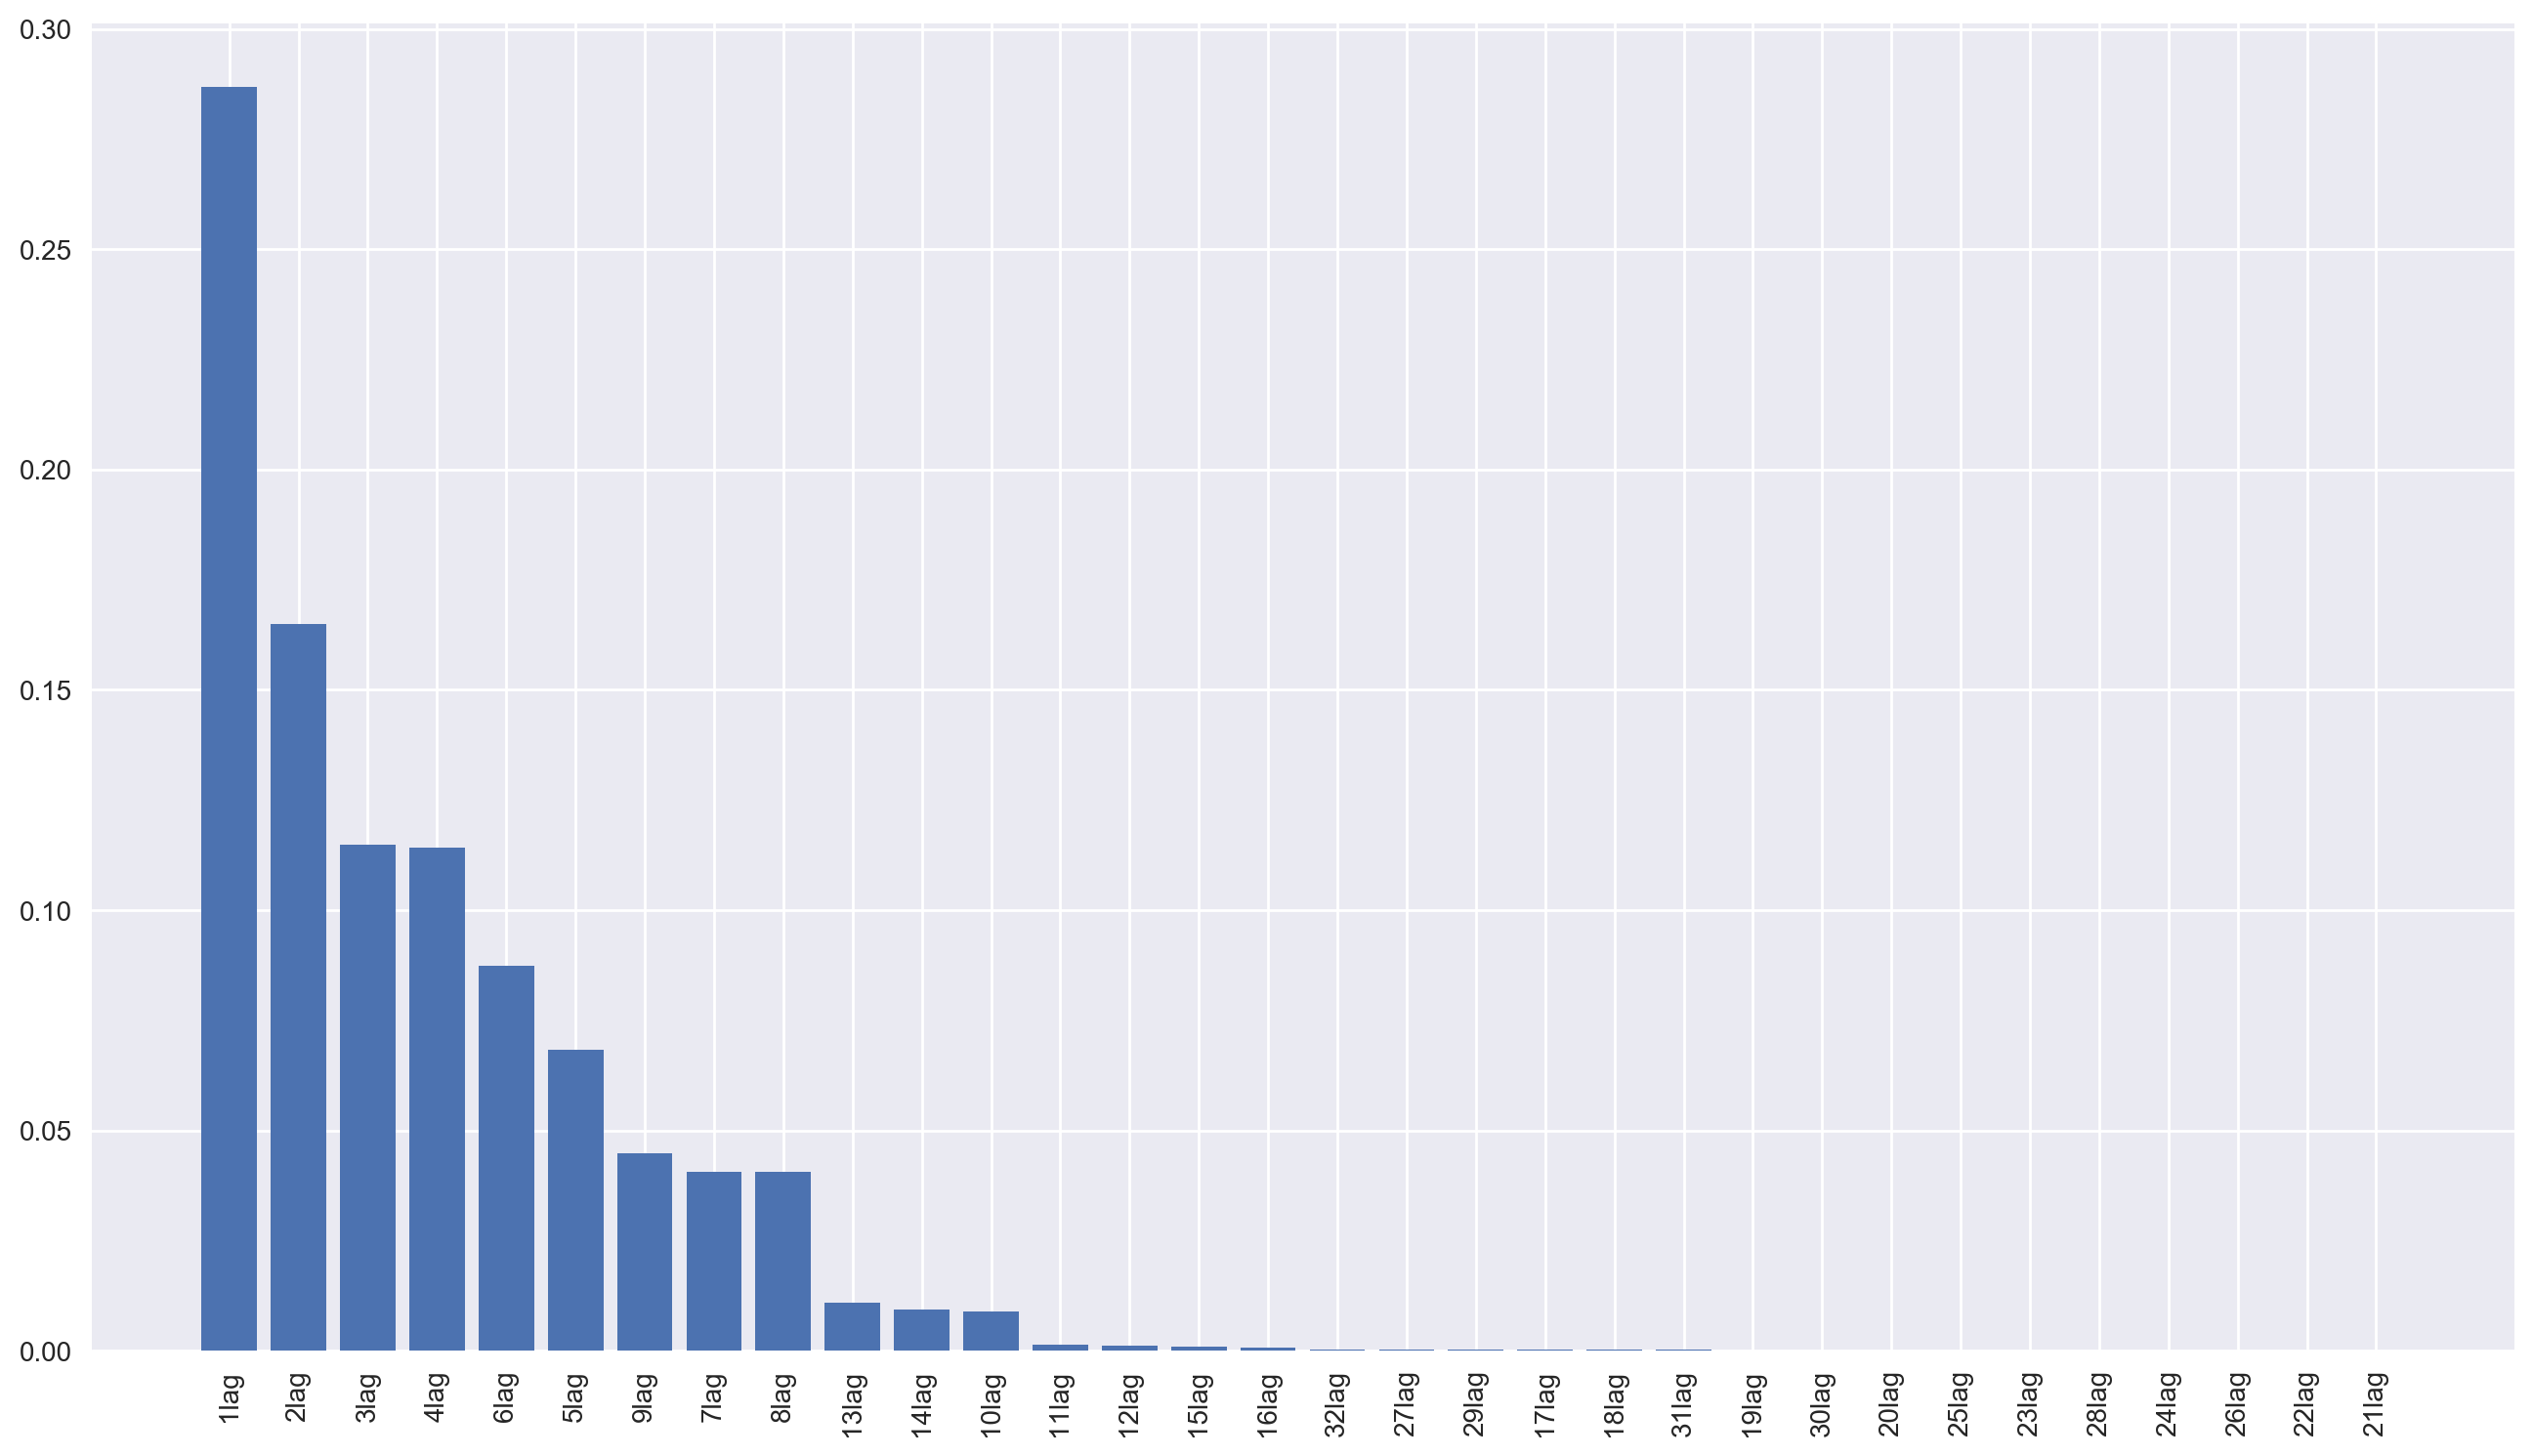

In [69]:
# Get feature importances from our gradient boosting model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

# Trading Algorithm with ML Models
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

<b>Ensemble Model</b><br>
Ensembling is a method for combining base models and is based on the hypothesis that a much more powerful model can be produced by combining multiple models together. There are different types of ensemble modelling:<br>
<ul>
    <li><b>Bagging</b>: short for bootstrap aggregation, uses bootstrap sampling to obtain data subsets for training 'base learners' and reduces variance. The most common algorithm is Random Forest, the process of generation is parallel and the base learner output in regression is averaging,</li>
    <li><b>Boosting</b>: converts 'weak learners' to strong learners and reduces bias. The most common algorithm is AdaBoost, the process of generation is sequential and the base learner output in regression is weighted sum,</li>
    <li><b>Stacking</b>: combines multiple models via a meta-model and improves predictions</li>
</ul>
In this section, we will only tackle the first two methods on Py35 compatibility grounds, since <code>scikit-learn</code> library's version in the Zipline environment is 0.20.0 and the stacking method was only introduced in release 0.22.0 (see link herebelow). No package version 0.22 or higher compatible with py35 has been found neither in conda main or alternative channels (check the following cell). <code>conda update</code> also fails to update the package to a newer version.

<code>scikit-learn</code>'s [release 0.22.0](https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_0_22_0.html)

In [3]:
!conda search -c anaconda scikit-learn=0.22=py35* --info

Loading channels: done
No match found for: scikit-learn==0.22[build=py35*]. Search: *scikit-learn*==0.22[build=py35*]

PackagesNotFoundError: The following packages are not available from current channels:

  - scikit-learn==0.22[build=py35*]

Current channels:

  - https://conda.anaconda.org/anaconda/linux-64
  - https://conda.anaconda.org/anaconda/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




<b>Neural Networks and Zipline</b><br>
<code>Keras</code> and <code>Tensorflow</code> are not supported in local Zipline research environment. Though having installed both, a message error is displayed when importing them. It appears that, to date, no satisfactory and technically feasible solutions have been found to port the DL algorithm into the Zipline local platform. For that reason, and regrettably enough, deep learning models cannot be performed in this project but will be explored in the future.<br>

Particularly, Long-Short Term Memory (LSTM) and Echo State Networks (ESN) models, falling under the family of  Recurrent Neural Networks, seem to work fine with financial time series, since they are able to capture non-linear relationships among variables and correct for vanishing gradient descents.

### Import Libraries

In [60]:
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import scale, StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, ParameterGrid, cross_val_score, cross_val_predict, cross_validate

from sklearn.metrics import r2_score

### Train, Test, Split

Considering that, on grounds of serial autocorrelation and time-varying standard deviation, financial times series are not independently and identically distributed, we shall use TimeSeriesSplit object from sklearn to allow for incremental cross validation. It is important in time series prediction that train, validation, test splits are in chronological order. Failure to do so will result in model's <i>information leak</i>.

In [25]:
tscv = TimeSeriesSplit(n_splits=10)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

(643, 32) (643, 8)
(635, 32) (635, 8)
(1278, 32) (1278, 8)
(635, 32) (635, 8)
(1913, 32) (1913, 8)
(635, 32) (635, 8)
(2548, 32) (2548, 8)
(635, 32) (635, 8)
(3183, 32) (3183, 8)
(635, 32) (635, 8)
(3818, 32) (3818, 8)
(635, 32) (635, 8)
(4453, 32) (4453, 8)
(635, 32) (635, 8)
(5088, 32) (5088, 8)
(635, 32) (635, 8)
(5723, 32) (5723, 8)
(635, 32) (635, 8)
(6358, 32) (6358, 8)
(635, 32) (635, 8)


## ML Models Design
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

Most commonly used scoring metric: mean squared value, negated so as to uniform sklearn handling <br>
 
 <blocquote>MSE = $\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}$</blocquote> <br>
 
 the closer to zero values, the better

### 1. Linear Regression

In [168]:
# Just in case we need to feed linear regression model with two numpy arrays, and in case of target with just one variable\n
# Apparently, not the case
# X = np.array(X).reshape(len(np.array(X)), -1)

# y = y.drop(columns=y.columns[list(map(lambda x:int(x[0])<8, y.columns))])
# y = np.array(y).reshape(len(np.array(y)), -1)

In [27]:
# Evaluate Linear

# Instantiate a DummyRegressor with 'median' strategy
linear = linear_model.LinearRegression()

# Fit the model
linear.fit(X_train, y_train)

# Make predictions
linear_pred = linear.predict(X_test)

# Make predictions
linear_train_pred = linear.predict(X_train)
linear_test_pred = linear.predict(X_test)

# Print scores
print(linear.score(X_train, y_train))
print(linear.score(X_test, y_test))

# Calculate accuracy using `cross_val_score()` with model instantiated, data to fit, target variable, 'neg_mean_absolute_error' scoring, cross validator, n_jobs=-1, and error_score set to 'raise'
linear_scores = cross_val_score(linear, X, y, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1, error_score='raise')

# Print mean and standard deviation of n_scores:
print('MSE: mean (%.3f), std (%.3f)' % (np.mean(linear_scores), np.std(linear_scores)))

0.9863928333309072
0.9660475528447326
MSE: mean (-358.520), std (907.205)


Surprisingly enough, 
<ul>
    <li> there is no need to pass a MultiOutputRegressor considering the Multi Target Regression problem stated</li>
    <li> even in the face of non stationary series (prices not returns), the model's goodness of fit is very high and the error term comparatively low</li>
    <li> it will be very difficult to beat our baseline model (...)</li>
</ul>

### 2. Support Vector Machine

In [28]:
# Evaluate baseline model

# Instantiate a Support Vector Regressor with 'rbf' kernel, gamma set to 'scale', and regularization parameter set to 10
svr = SVR(kernel='rbf',gamma='scale',C=10)

# Pass a MultiOutputRegressor to model
svr = MultiOutputRegressor(svr)

# Fit the model
svr.fit(X_train, y_train)

# Make predictions
svr_pred = svr.predict(X_test)

# Make predictions
svr_train_pred = svr.predict(X_train)
svr_test_pred = svr.predict(X_test)

# Print scores
print(svr.score(X_train, y_train))
print(svr.score(X_test, y_test))

# Calculate accuracy using `cross_val_score()` with model instantiated, data to fit, target variable, 'neg_mean_absolute_error' scoring, cross validator 'cv', n_jobs=-1, and error_score set to 'raise'
svr_scores = cross_val_score(svr, X, y, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1, error_score='raise')

# Print mean and standard deviation of m_scores: 
print('Good: %.3f (%.3f)' % (np.mean(svr_scores), np.std(svr_scores)))

0.8711796462148237
0.09610270619480135
Good: -16860.875 (34043.905)


### 3. Decision Trees

R^2 train: 0.9893, R^2 test: 0.9114


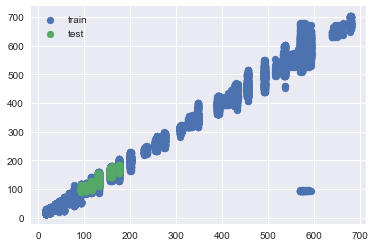

Negative mean squared error: -4897.6613 (12357.8164)


In [31]:
# Let's use max_depth = 5 to fit again our DT model
dt = DecisionTreeRegressor(max_depth=5)
dt.fit(X_train, y_train)

# Predict values from train and test
dt_train_pred = dt.predict(X_train)
dt_test_pred = dt.predict(X_test)

# Score on train/test sets
score_train = r2_score(y_train, dt_train_pred)
score_test = r2_score(y_test, dt_test_pred)
print('R^2 train: %.4f, R^2 test: %.4f' % (score_train, score_test))

# Scatter prediction vs actual values
plt.scatter(dt_train_pred, y_train, label='train')
plt.scatter(dt_test_pred, y_test, label='test')
plt.legend()
plt.show()

# Print mean and standard deviation of m_scores: 
dt_scores = cross_val_score(dt, X, y, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1, error_score='raise')
print('Negative mean squared error: %.4f (%.4f)' % (np.mean(dt_scores), np.std(dt_scores)))


Still, linear regression performs better in terms of test's goodness of fit $R^2$ and model's error.


### 3. Random Forest

In [86]:
param_grid = {'max_depth' : np.arange(5,11)} 
# Create grid search object
# this uses tscv

rfr = RandomForestRegressor()

rfr = GridSearchCV(rfr, param_grid = param_grid, cv = tscv, n_jobs=-1)

# Fit on data
best_rfr = rfr.fit(X, y)

best_hyperparams = best_rfr.best_estimator_.get_params()
best_hyperparams

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [87]:
# First, create an Instance
rfr = RandomForestRegressor()

# Second, create a dictionnary of hyperparameters to search
grid = {'n_estimators': [10, 100], 'max_depth': [3, 6], 'max_features': ['auto', 4, 8], 'random_state': [42]}
test_scores = []

# Third, loop over the parameter grid, set the hyperparameters and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g) # unpack the dictionnary
    rfr.fit(X_train, y_train)
    test_scores.append(rfr.score(X_test, y_test))
    
# Fourth, find best hyperparameters
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.9501444180870959 {'max_depth': 6, 'n_estimators': 10, 'random_state': 42, 'max_features': 'auto'}


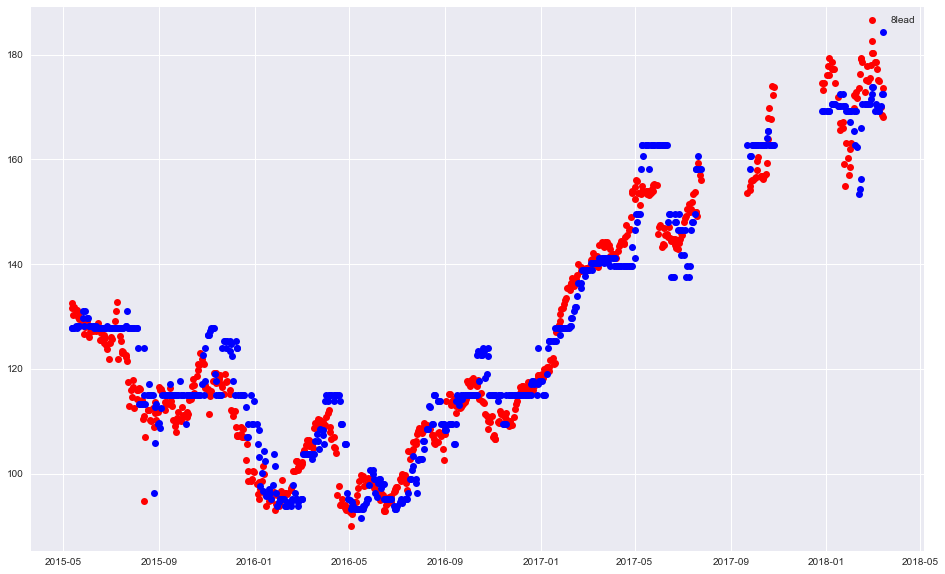

0.9947337361541527
0.9501444180870959


In [88]:
# Instantiate the model
rfr = RandomForestRegressor(n_estimators = 10, max_depth = 6, max_features = 'auto', random_state = 42)

# Fit the model
rfr.fit(X_train, y_train)

# Make predictions
train_pred_rfr = rfr.predict(X_train)
test_pred_rfr = rfr.predict(X_test)

# Create a scatter plot with train and test actual vs predictions
plt.figure(figsize=(16,10))

plt.plot(y_test.index, y_test['8lead'], 'ro')
plt.plot(y_test.index, test_pred_rfr[:,7], 'bo')
plt.legend()
plt.show()

# Print scores
print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

In [33]:
# Negative mean squared error
m_scores = cross_val_score(rfr, X, y, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1, error_score='raise')
print('Good: %.3f (%.3f)' % (np.mean(m_scores), np.std(m_scores)))

Good: -4853.415 (12292.913)


### 4. Gradient Boosting

Except for prices nosedive in 2014, almost all of our ten time series' cross-validation splits exhibit higher prices in test than in train. Hence, we shall conduct an exercise with scaled data for this Gradient Boosting model and compare scoring results with non-scaled data.

In [114]:
# Standardize the train and test features
scaled_X_train = scale(X_train)
scaled_X_test = scale(X_test)
scaled_y_train = scale(y_train)
scaled_y_test = scale(y_test)

In [115]:
# Create GB model -- hyperparameters (to be tuned!!)
gbr = GradientBoostingRegressor()

# For multiple target predictions, we shall use MultiOutputRegressor
gbr = MultiOutputRegressor(gbr)

# Fit the model
gbr.fit(scaled_X_train, scaled_y_train)

# Make predictions
train_pred_gbr = gbr.predict(scaled_X_train)
test_pred_gbr = gbr.predict(scaled_X_test)

# Print scores
print(gbr.score(scaled_X_train, scaled_y_train))
print(gbr.score(scaled_X_test, scaled_y_test))

0.9980773376911474
0.9274253041290585


With non-scaled data.<br>
We've tried to conduct some hyperparameter tuning but a ValueError pops up referring to the MultiOutputRegressor method. However, we tried different parameter grid combinations herebelow.

In [120]:
gbr = GradientBoostingRegressor(
    loss='ls',
    learning_rate=0.01,
    n_estimators=50,
    subsample=1.0,
    criterion='friedman_mse',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=32,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    init=None,
    random_state=None,
    max_features=None,
    alpha=0.9,
    verbose=1,
    max_leaf_nodes=None,
    warm_start=False,
    presort='auto',
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001
)
gbr = MultiOutputRegressor(gbr)

# Fit the model
gbr.fit(X_train, y_train)

# Make predictions
train_pred_gbr = gbr.predict(X_train)
test_pred_gbr = gbr.predict(X_test)

# Print scores
print(gbr.score(X_train, y_train))
print(gbr.score(X_test, y_test))

      Iter       Train Loss   Remaining Time 
         1       24129.2192           32.25s
         2       23649.0478           31.19s
         3       23178.4317           30.39s
         4       22717.1809           29.67s
         5       22265.1090           28.97s
         6       21822.0334           28.29s
         7       21387.7749           27.62s
         8       20962.1582           26.96s
         9       20545.0112           26.30s
        10       20136.1655           25.65s
        20       16469.5095           19.18s
        30       13470.5261           12.86s
        40       11017.6367            6.62s
        50        9011.4015            0.00s
      Iter       Train Loss   Remaining Time 
         1       24128.0079           37.97s
         2       23647.8605           36.92s
         3       23177.2681           36.07s
         4       22716.0405           35.13s
         5       22263.9913           34.32s
         6       21820.9378           33.52s
        

In [121]:
# Create GB model
gbr = GradientBoostingRegressor()

# For multiple target predictions, we shall use MultiOutputRegressor
gbr = MultiOutputRegressor(gbr)

# Fit the model
gbr.fit(X_train, y_train)

# Make predictions
train_pred_gbr = gbr.predict(X_train)
test_pred_gbr = gbr.predict(X_test)

# Print scores
print(gbr.score(X_train, y_train))
print(gbr.score(X_test, y_test))

0.9980773376915619
0.956348041545338


In [122]:
cross_validate(gbr, X, y=y, cv=tscv, scoring='neg_mean_squared_error')

{'fit_time': array([0.62428808, 1.01034331, 1.43958664, 2.3117106 , 2.96878338,
        3.60239697, 5.05423617, 6.40546632, 7.13661003, 8.12977147]),
 'score_time': array([0.00399399, 0.00402808, 0.00404263, 0.00424647, 0.00377321,
        0.00397468, 0.00519133, 0.00500512, 0.0049181 , 0.00462365]),
 'test_score': array([-1.59617763e+01, -3.43392404e+01, -4.07400165e+02, -7.13576190e+01,
        -2.66233499e+01, -1.49477277e+02, -4.93898737e+02, -3.93689897e+04,
        -4.59243583e+03, -2.36186468e+01]),
 'train_score': array([ -1.90168504,  -3.27044581,  -3.49134837,  -4.82289603,
         -5.49348642,  -5.935742  ,  -7.65041041, -12.69871515,
        -23.46167846, -47.32368843])}

In [123]:
def plotme(y_test, test_pred_gbr, col, step):
    plt.figure(figsize=(16,10))

    plt.plot(y_test.index, y_test[col], 'ro')
    plt.plot(y_test.index, test_pred_gbr[:,step], 'bo')

    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.legend()
    plt.show();

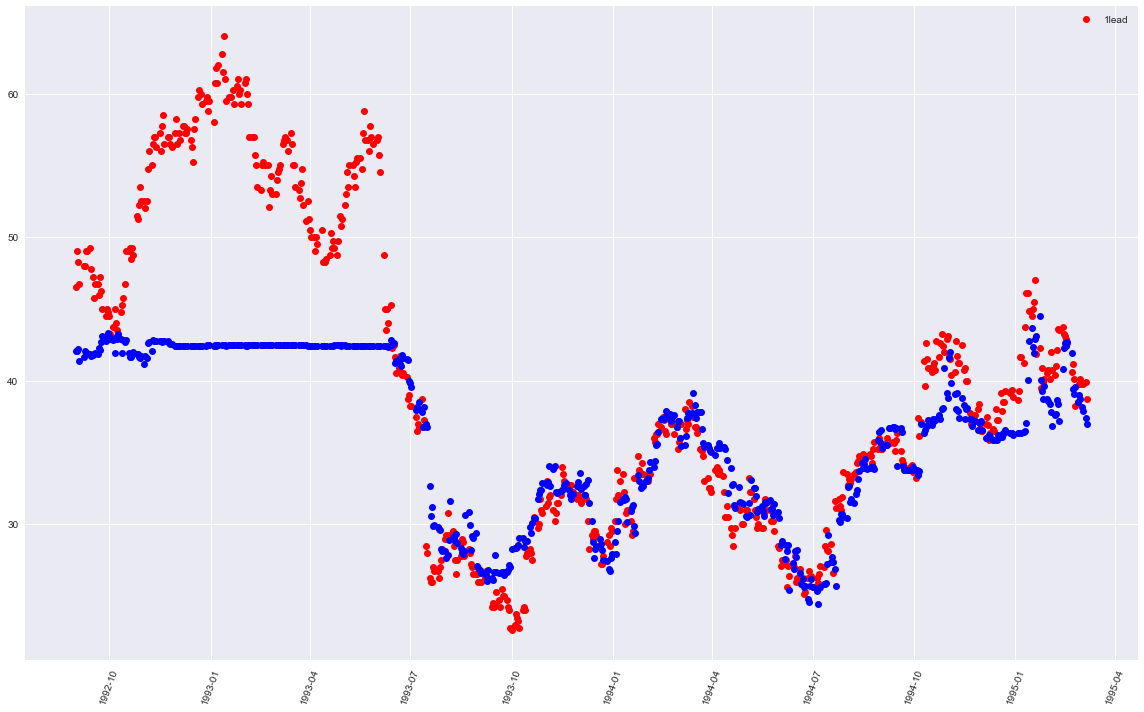

Train Score: 0.9090731595199764
Test Score: 0.9403618024732286


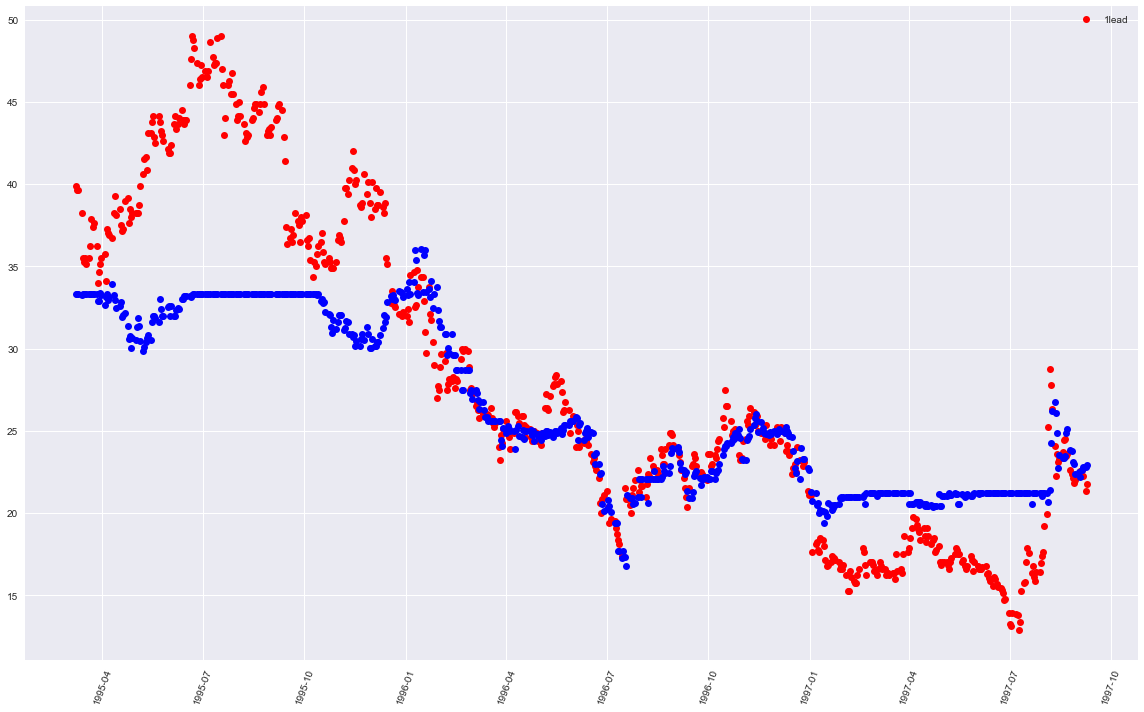

Train Score: 0.9369039737558278
Test Score: 0.9576891266501537


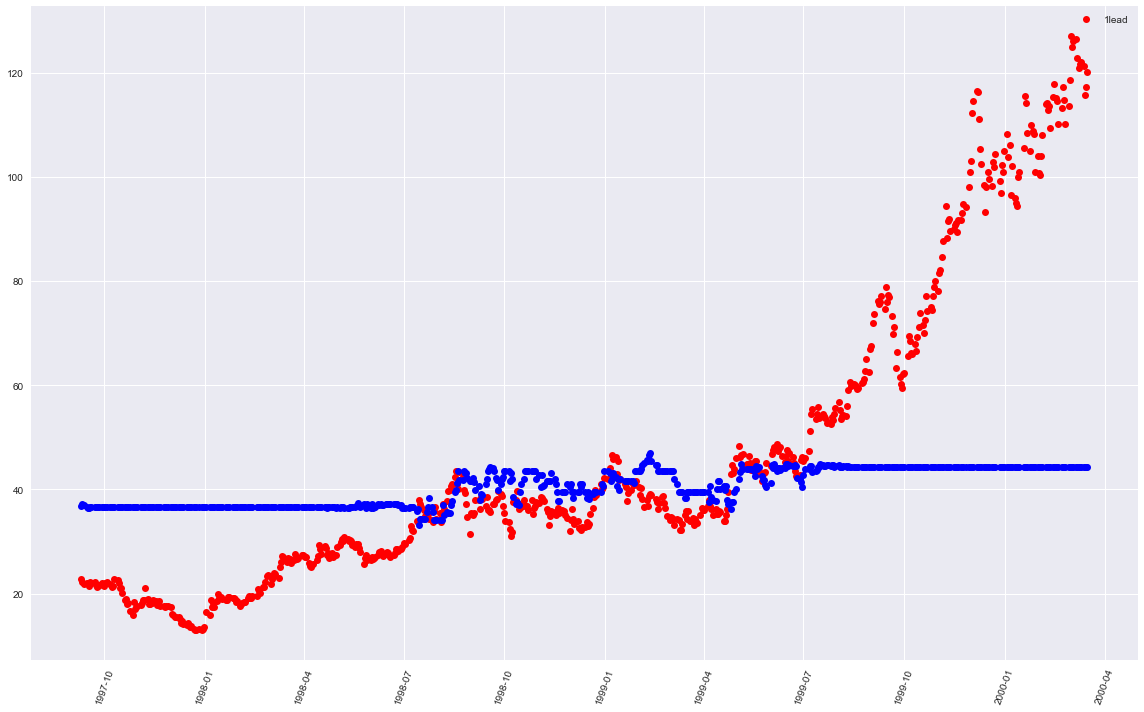

Train Score: 0.961677353901101
Test Score: 0.9783395159832904


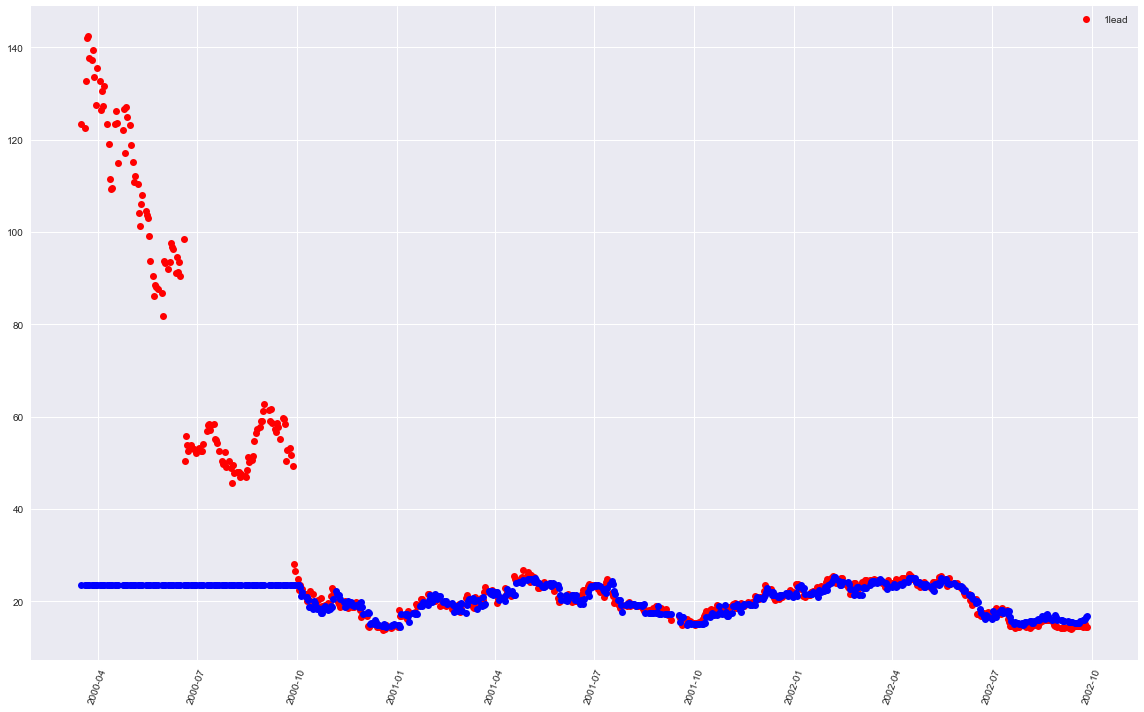

Train Score: 0.9730475457767342
Test Score: 0.9611241914310414


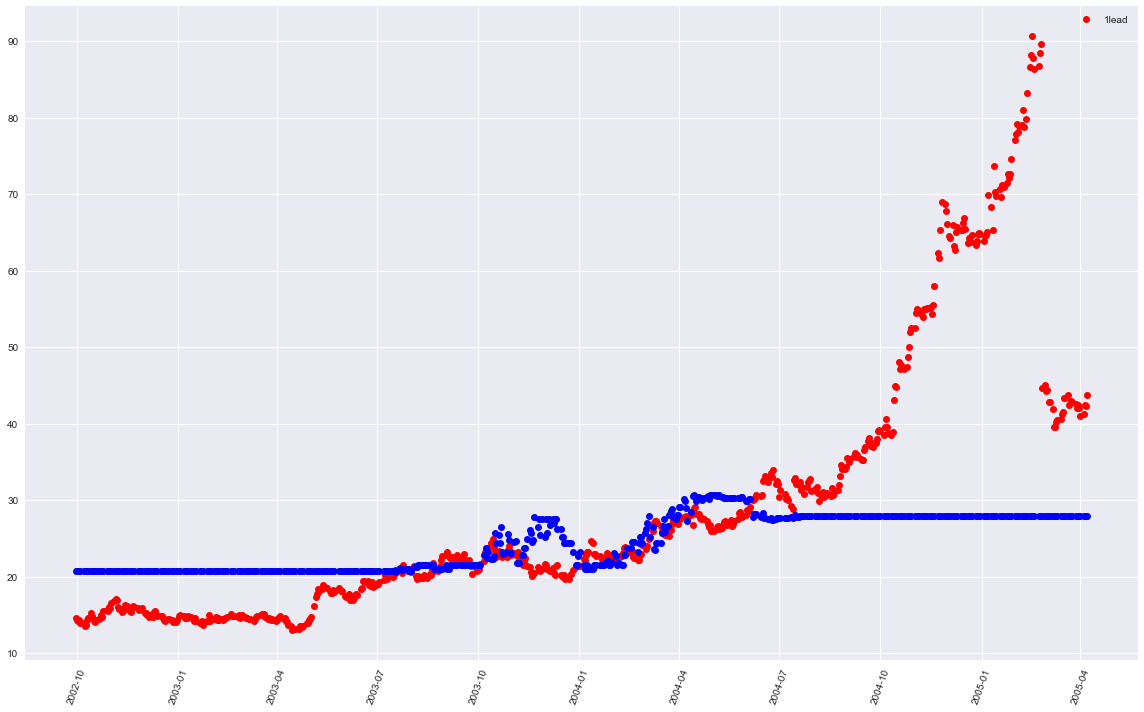

Train Score: 0.9697055837565536
Test Score: 0.9470989069407553


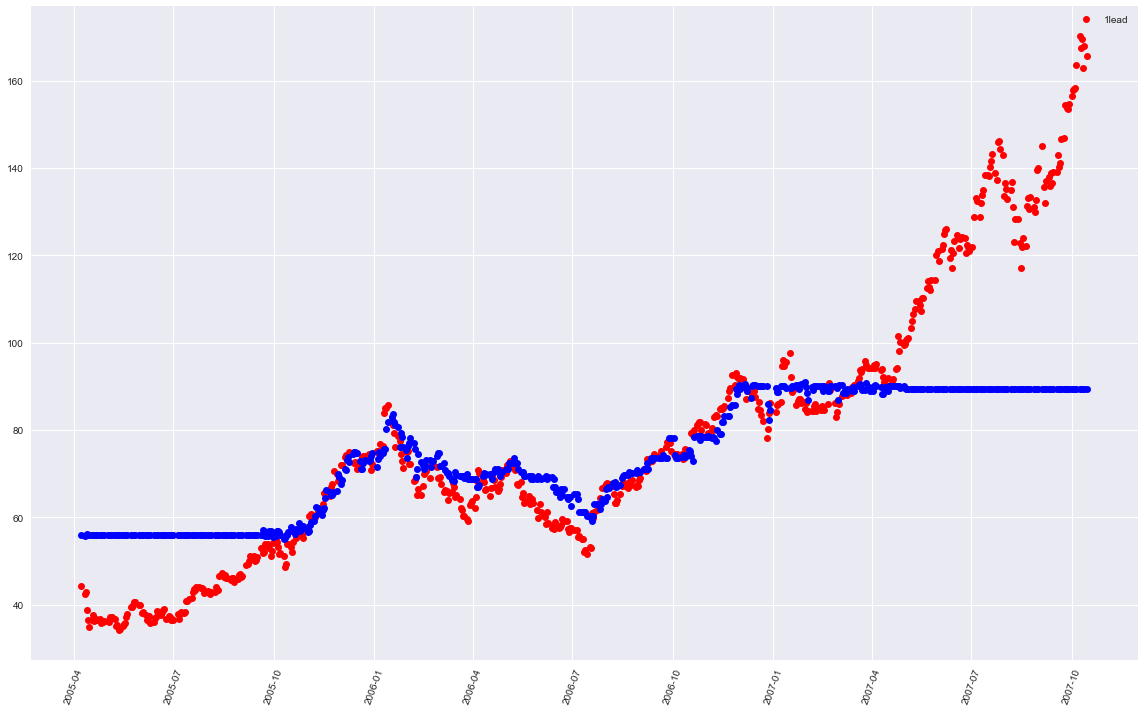

Train Score: 0.968065651231385
Test Score: 0.9811739121394293


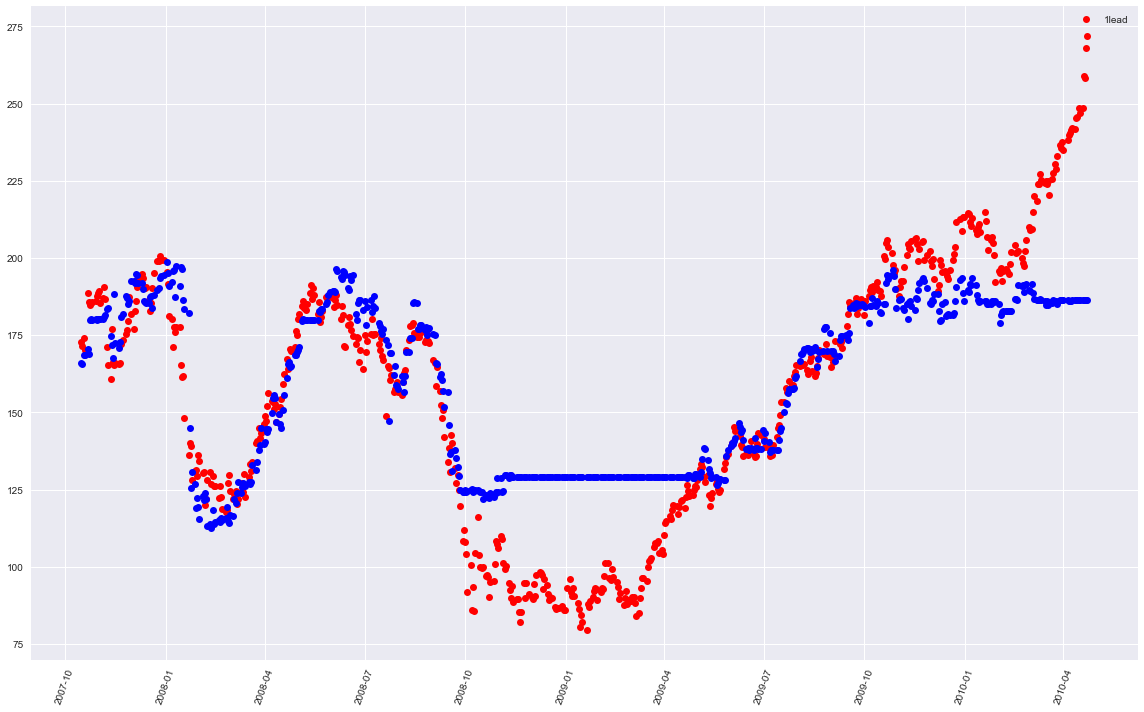

Train Score: 0.9798273114824065
Test Score: 0.9627521616765501


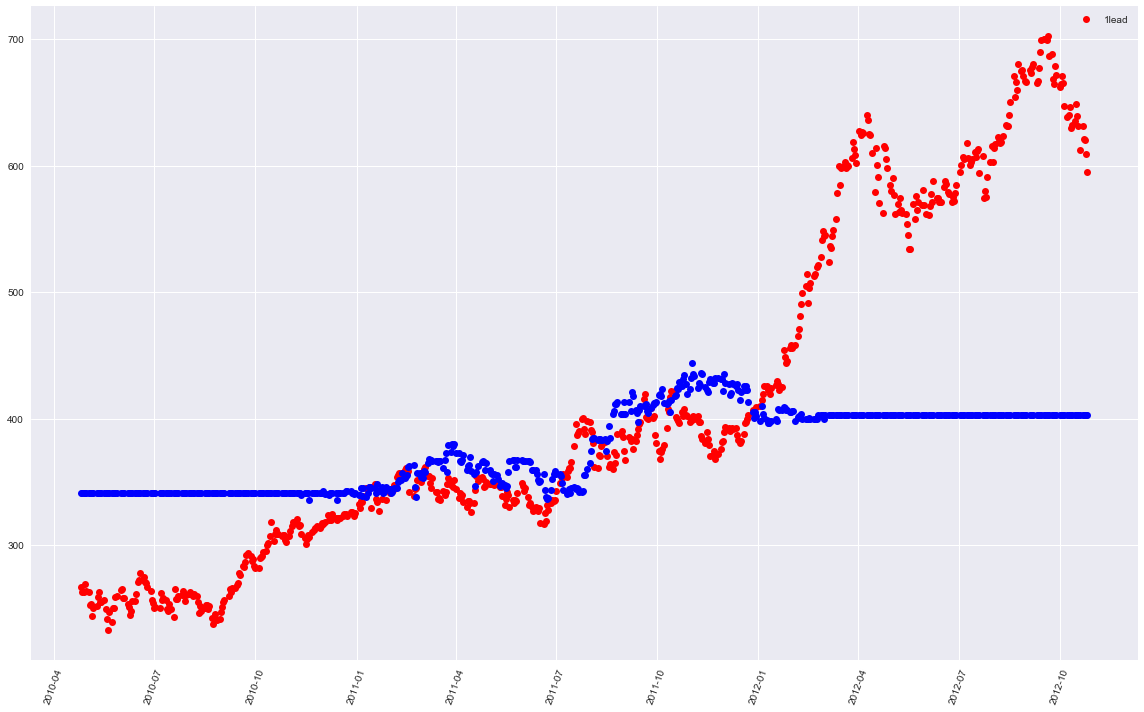

Train Score: 0.9905684246003461
Test Score: 0.9925583090987363


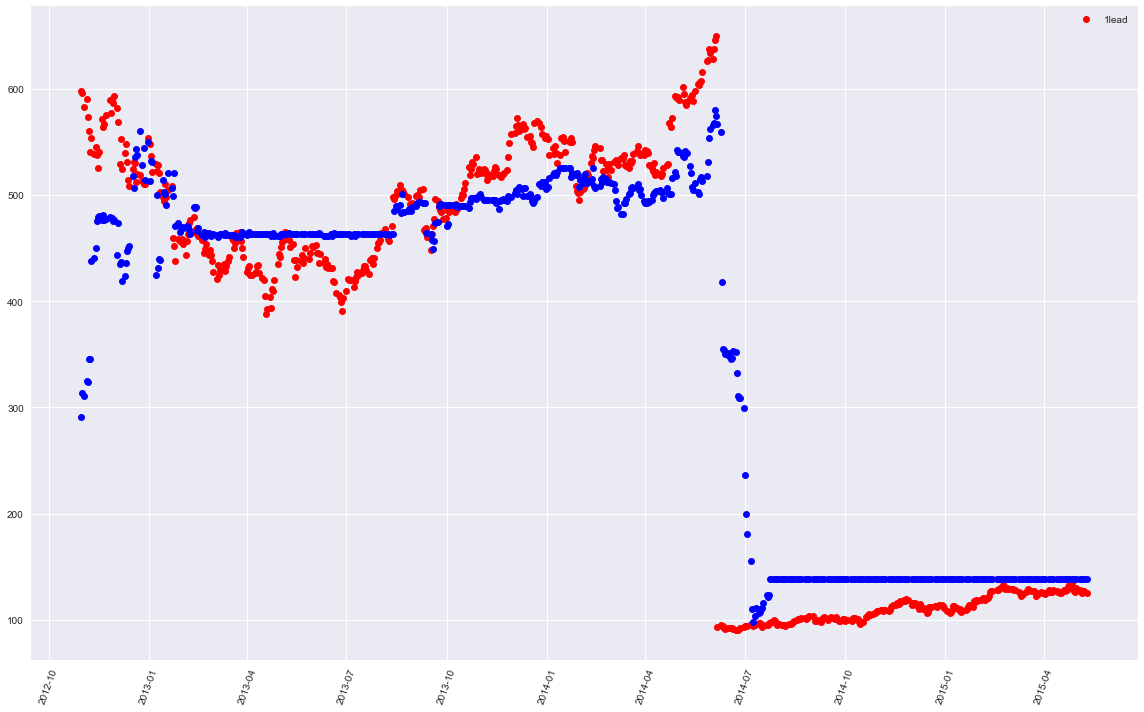

Train Score: 0.9979651664289705
Test Score: 0.99548816012594


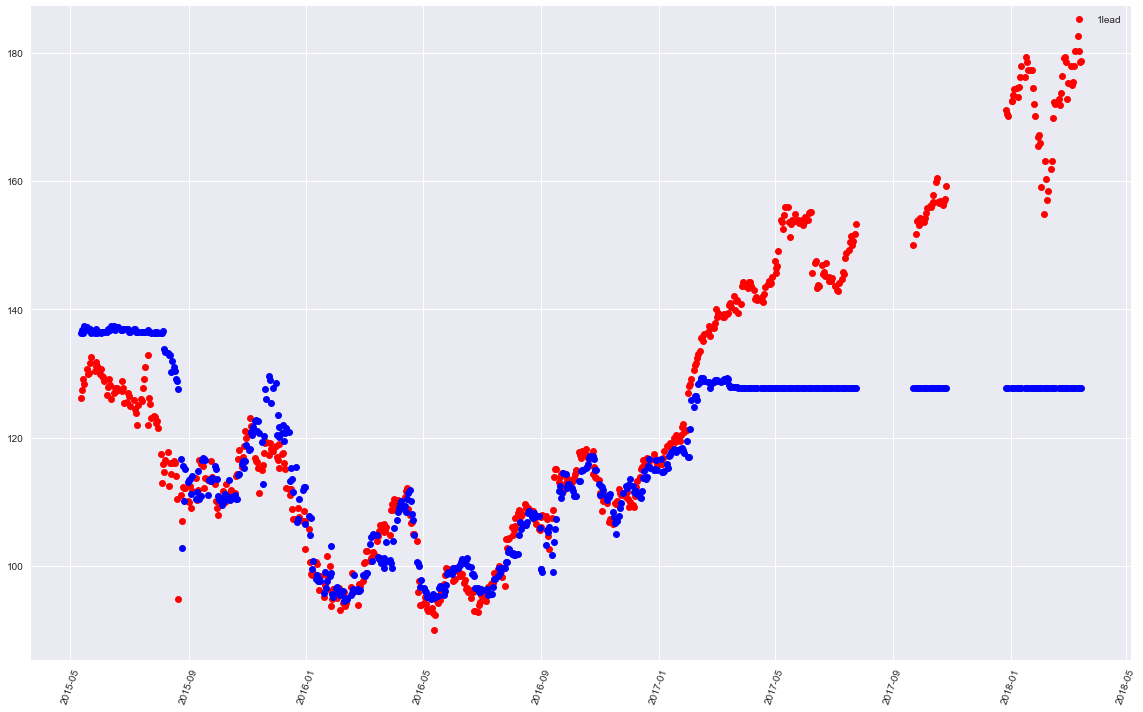

Train Score: 0.9980773376915619
Test Score: 0.956348041545338


In [124]:
from sklearn.model_selection import cross_val_predict

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    test_pred_gbr = cross_val_predict(gbr, X_test, y=y_test)
    plotme(y_test, test_pred_gbr, '1lead', 0)
    print('Train Score: {}'.format(gbr.score(X_train, y_train)))
    print('Test Score: {}'.format(gbr.score(X_test, y_test)))

From the cross-validation method iteration, we can appreciate how the metrics ameliorate in the last sample (equal the whole dataset).

### 5. AdaBoost

In [172]:
# Create GB model -- hyperparameters (to be tuned!!)
adar = AdaBoostRegressor()

# For multiple target predictions, we shall use MultiOutputRegressor
adar = MultiOutputRegressor(adar)

# Fit the model
adar.fit(X_train, y_train)

# Make predictions
train_pred_gbr = adar.predict(X_train)
test_pred_gbr = adar.predict(X_test)

# Print scores
print(adar.score(X_train, y_train))
print(adar.score(X_test, y_test))

0.992006564635969
0.8778256218912449


### 6. K-Neighbors

K-nearest neighbors (KNN) calculate euclidean distances from neighbouring poins to compute predictions. In order to prevent that big features outweigh small ones, scaling data is necessary. Sklearn's <code>scale()</code> can standardize data setting the mean to 0 and standard deviation to 1.

In [ ]:
best_model('KNN', KNeighborsRegressor())

In [42]:
# Standardize the train and test features
scaled_X_train = scale(X_train)
scaled_X_test = scale(X_test)
scaled_X = scale(X)

In [46]:
# Create and fit the KNN model
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model
knn.fit(scaled_X_train, y_train)

# Make predictions
knn_pred = knn.predict(scaled_X_test)

# Make predictions
knn_train_pred = knn.predict(scaled_X_train)
knn_test_pred = knn.predict(scaled_X_test)

# Print scores
print(knn.score(scaled_X_train, y_train))
print(knn.score(scaled_X_test, y_test))
 
# Second, create a dictionnary of hyperparameters to search
knn_scores = cross_val_score(knn, scaled_X, y, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1, error_score='raise')
    
# Print mean and standard deviation of m_scores: 
print('Good: %.3f (%.3f)' % (np.mean(knn_scores), np.std(knn_scores)))


0.9970351876200172
-26.734954047884965
Good: -5088.607 (11897.964)


0.9970351451284329
0.27374876982235885


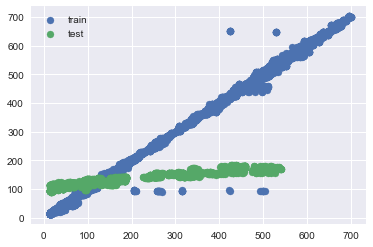

In [63]:
# Plot the actual vs predicted values
plt.scatter(knn_train_pred, y_train, label='train')
plt.scatter(knn_test_pred, y_test, label='test')
plt.legend()

print(r2_score(knn_train_pred, y_train))
print(r2_score(knn_test_pred, y_test))


The best performing models have been Linear Regression (baseline), Gradient Boosting and Random Forest. After undertaking some hyperparameter tuning in both GB and RF and scaling data in the former, it appears that Gradient Boosting (default parameters) becomes slightly better results than Linear Regression. Nonetheless, the series' last year performs badly. <br>
As Our trading window spans 635 days (corresponding to our test sample), we will have to be very careful with our portfolio's value during the last year.

### Export best model in a joblib format

In [125]:
# Export trained models and save it for future predictions
from joblib import dump
dump(gbr, '../strategies/models/gbr_regressor.joblib')

['../strategies/models/gbr.joblib']

## Plug-in Best Model implementation into Trading Bot
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

We modify the <code>buy_and_hold.py</code> Python script (strategies folder) to account for, ceteris paribus:
<ul>
    <li>lagged and forecast values</li>
    <li>under the <code>initialize </code>function, load our RF regressor joblib </li>
    <li>under the <code>handle_data</code> function:<br>
        <ol>
        <li>create one array with lagged 32 values for each point in time and  one array with 8 forecast values, and</li>
        <li>code the strategy: if the max predictive value is above the mean of historical/past values, then we place a buy order and viceversa</li>
        </ol>
    

The portfolio value has reached a value of round 228 million EUR, whereas the classic strategy BuyAndHold recorded a value of round 561.100 EUR.

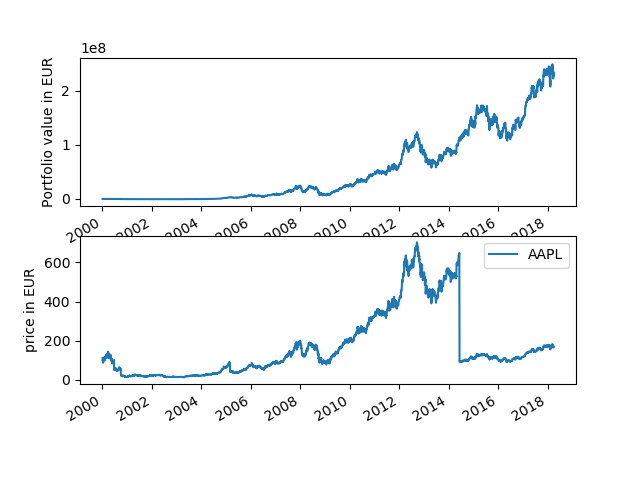

## Backtest ML Trading Strategy
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

In [35]:
df = pd.read_csv('../reports/buy_and_hold.csv')

In [36]:
df = df.rename(columns={'Unnamed: 0':'date'}).set_index('date')

<Figure size 1296x576 with 0 Axes>

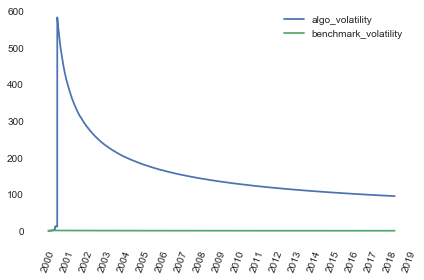

In [48]:
from matplotlib import pyplot as plt
from matplotlib.dates import YearLocator, date2num, DateFormatter

plt.figure(figsize = (18, 8))

df.index = pd.DatetimeIndex(df.index)

fig, ax = plt.subplots()

fig.subplots_adjust(bottom=0.3)

# Create a plot
ax.plot(df.index, df.algo_volatility)
ax.plot(df.index, df.benchmark_volatility)

lctr = YearLocator()
frmt = DateFormatter('%Y')

# Final formatting
ax.xaxis.set_major_locator(lctr)
ax.xaxis.set_major_formatter(frmt)

plt.xticks(rotation=70)
plt.tight_layout()

plt.legend()
plt.show()

<Figure size 1296x576 with 0 Axes>

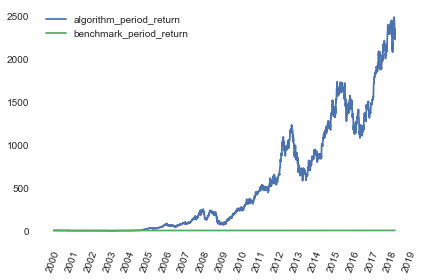

In [49]:
from matplotlib import pyplot as plt
from matplotlib.dates import YearLocator, date2num, DateFormatter

plt.figure(figsize = (18, 8))

df.index = pd.DatetimeIndex(df.index)

fig, ax = plt.subplots()

fig.subplots_adjust(bottom=0.3)

# Create a plot
ax.plot(df.index, df.algorithm_period_return)
ax.plot(df.index, df.benchmark_period_return)

lctr = YearLocator()
frmt = DateFormatter('%Y')

# Final formatting
ax.xaxis.set_major_locator(lctr)
ax.xaxis.set_major_formatter(frmt)

plt.xticks(rotation=70)
plt.tight_layout()

plt.legend()
plt.show()

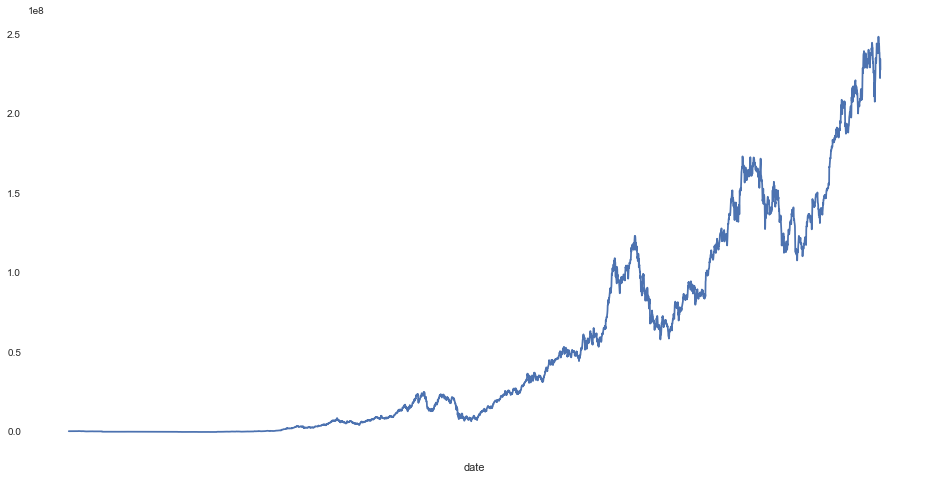

In [37]:
df.portfolio_value.plot(figsize=(16,8))

In [38]:
'${:.2f}'.format(df.capital_used.sum())

'$-33730147.25'

In [39]:
'${:.2f}'.format(df.portfolio_value[-1])

'$227667200.75'

In [40]:
'${:.2f}'.format(df.capital_used.sum() + df.portfolio_value[-1])

'$193937053.51'